This notebook is for analysing the patient presence at the hospitals.

Result should be, for each patient:
- a list of 61 days marked with a 0
- the middle day is matched with the surgery action date and marked with a 1
- any other inpatient or outpatient days for the same case to be marked with a 1
- this yields a square signal for patient's attendance

In [3]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data File:

In [13]:
file_name = 'tiny.csv'
file_name = 'aaaPas 2024-05-15.csv'
# Read in Data File
df = pd.read_csv(file_name)

/tmp/ipykernel_181972/1360426632.py:4: DtypeWarning: Columns (27,28,29,30,31,32,33,34,43,44,45,46,47,48,49,50,51,52,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [45]:
# Data details
display(df.head(4))

print("Data column names are:\n===")
for sl_num, name in enumerate(df.columns):
    if not np.mod(sl_num, 4):
        print(" ")
    print("{}:\t{}\t".format(sl_num, name))
last_sl_num = df["val_lopnr"].iloc[-1]
total_num_patients = len(set(df["val_lopnr"]))

print("\n\n---\nLast serial number of patient in data:\t {}".format(last_sl_num))
print("Total number of patients in data:\t {}".format(total_num_patients))
print("Missing patients in data:\t\t {}".format(last_sl_num - total_num_patients))

,ID,lopnr,val_lopnr,birth_year_month,Sex,RefActionDate,DocumentID,IsReference,TimestampSaved,SavedAtCareUnitID,...,ActionCode18,ActionCode19,ActionCode20,ActionCode21,ActionCode22,Mosaic,Usaett,LastMoveDate,LastMoveDirection,NumberOfEarlierVisits
0,296473,97508,1,01/08/1942,K,15/03/2020,3277,1,16/03/2020,5091,...,NaN,NaN,NaN,NaN,NaN,1.Bttre bemedlade,1.0,NaN,NaN,8.0
1,294480,97508,1,01/08/1942,K,15/03/2020,3485,0,24/03/2020,4264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2,293891,97508,1,01/08/1942,K,15/03/2020,3547,0,24/03/2020,5065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
3,296589,97508,1,01/08/1942,K,15/03/2020,3552,0,27/03/2020,5091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


Data column names are:
===
 
0:	ID	
1:	lopnr	
2:	val_lopnr	
3:	birth_year_month	
 
4:	Sex	
5:	RefActionDate	
6:	DocumentID	
7:	IsReference	
 
8:	TimestampSaved	
9:	SavedAtCareUnitID	
10:	NameOfCareUnit	
11:	IsInpatient	
 
12:	StartDatetime	
13:	EmergencyID	
14:	DischargeDateTime	
15:	DiagnosisCode1	
 
16:	DiagnosisCode2	
17:	DiagnosisCode3	
18:	DiagnosisCode4	
19:	DiagnosisCode5	
 
20:	DiagnosisCode6	
21:	DiagnosisCode7	
22:	DiagnosisCode8	
23:	DiagnosisCode9	
 
24:	DiagnosisCode10	
25:	DiagnosisCode11	
26:	DiagnosisCode12	
27:	DiagnosisCode13	
 
28:	DiagnosisCode14	
29:	DiagnosisCode15	
30:	DiagnosisCode16	
31:	DiagnosisCode17	
 
32:	DiagnosisCode18	
33:	DiagnosisCode19	
34:	DiagnosisCode20	
35:	DiagnosisCodePre1	
 
36:	DiagnosisCodePre2	
37:	DiagnosisCodePre3	
38:	DiagnosisCodePre4	
39:	DiagnosisCodePre5	
 
40:	DiagnosisCodePre6	
41:	DiagnosisCodePre7	
42:	DiagnosisCodePre8	
43:	DiagnosisCodePre9	
 
44:	DiagnosisCodePre10	
45:	DiagnosisCodePre11	
46:	DiagnosisCodePre12	
47:	Diagnosis

In [47]:
last_sl_num = df["val_lopnr"].iloc[-1]
total_num_patients = len(set(df["val_lopnr"]))

print("Last serial number of patient in data:\t {}".format(last_sl_num))
print("Total number of patients in data:\t {}".format(total_num_patients))
print("Missing patients in data:\t\t {}".format(last_sl_num - total_num_patients))

Last serial number of patient in data:	 260992
Total number of patients in data:	 241635
Missing patients in data:		 19357


### Make a container to hold square waves.

In [5]:
# Number of patients: last serial number in 'val_lopnr'
# 1 time string per patient
# time string length is 30 days before and after 'RefActionDate' for that patient = when surgery was performed
# time string length = 30 + 30 + 1 = 61
time_str_len = 61
num_patients = df['val_lopnr'].to_numpy()[-1]+1
time_strings = np.zeros((num_patients, time_str_len))
ts = time_strings[0,:]
print(np.shape(ts))
# print(np.shape(time_strings))

(61,)


In [6]:
event_start_dates = df.loc[df['val_lopnr']==1]['StartDatetime']
event_end_dates = df.loc[df['val_lopnr']==1]['DischargeDateTime'].fillna(0)

# print(event_start_dates)
# print(event_end_dates)

In [7]:
# Assign a name for RefActionDate 
idx30_date = pd.to_datetime(df.loc[df['val_lopnr']==1]['RefActionDate'][0], dayfirst=True)

# Set midpoint of list to RefActionDate
mid_point = 30
ts[mid_point] = 1

for i, j in zip(event_start_dates, event_end_dates):
    x = pd.to_datetime(i, dayfirst=True)
    print(x)
    print((x-idx30_date).days)
    start_offset = (x-idx30_date).days
    ts[mid_point + start_offset] = 1
    if j!=0: # When inpatient
        y = pd.to_datetime(j, dayfirst=True)
        print(y)
        print('interval is {}'.format((y-x).days))
        end_offset = (y-x).days
        ts[mid_point + start_offset : mid_point + start_offset + end_offset + 1] = 1
    else: # Delta when outpatient
        print(0)
    print('---')

2020-03-08 00:00:00
-7
2020-03-15 00:00:00
interval is 7
---
2020-03-20 00:00:00
5
0
---
2020-03-21 00:00:00
6
2020-03-23 00:00:00
interval is 2
---
2020-03-23 00:00:00
8
2020-03-26 00:00:00
interval is 3
---


In [8]:
def gen_dirac_timeseries(idx30_date, eventStarts, eventEnds):
    # Set midpoint of list to RefActionDate
    mid_point = 30
    ts = np.zeros(61)
    ts[mid_point] = 1
    
    for i, j in zip(event_start_dates, event_end_dates):
        x = pd.to_datetime(i, dayfirst=True)
        # print(x)
        # print((x-idx30_date).days)
        start_offset = (x-idx30_date).days
        # Always set event Start Date to 1, whether inpatient or outpatient
        ts[mid_point + start_offset] = 1
        if j!=0: # When inpatient
            y = pd.to_datetime(j, dayfirst=True)
            # print(y)
            # print('interval is {}'.format((y-x).days))
            end_offset = (y-x).days
            ts[mid_point + start_offset : mid_point + start_offset + end_offset + 1] = 1
        else: # Delta when outpatient
            None
            # print(0)
        # print('---')    
    return ts

In [9]:
num_missing_patients = 0
patient_count_bound = 20000# num_patients
for i in range(12, patient_count_bound):
    try: 
        # chunk = df.loc[df['val_lopnr']==i]['RefActionDate'].iloc[0]
        # print(chunk)
        # print(chunk[0])
        idx30_date = pd.to_datetime(df.loc[df['val_lopnr']==i]['RefActionDate'].iloc[0], dayfirst=True)
        # print(idx30_date)
        event_start_dates = df.loc[df['val_lopnr']==i]['StartDatetime']
        event_end_dates = df.loc[df['val_lopnr']==i]['DischargeDateTime'].fillna(0)
        time_strings[i, :] = gen_dirac_timeseries(idx30_date, event_start_dates, event_end_dates)
    except Exception as a:
        num_missing_patients += 1
        print(i)
        print(a)
        if num_missing_patients > 4:
            break
print('Total number of missing patients = {}/{}'.format(num_missing_patients, patient_count_bound))

 
aaa
12
single positional indexer is out-of-bounds
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
26
single positional indexer is out-of-bounds
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
32
index 64 is out of bounds for axis 0 with size 61
 
aaa
33
single positional indexer is out-of-bounds
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
bbb
ccc
ddd
 
aaa
37
single positional indexer is out-of-bounds
Total number of missing patients = 5/20000


/tmp/ipykernel_181972/1503668522.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  event_end_dates = df.loc[df['val_lopnr']==i]['DischargeDateTime'].fillna(0)


Notes:
1. If patient number is missing there is an error: `single positional indexer is out-of-bounds`
2. If patient diagnosis does not exist, there is an error: `index 64 is out of bounds for axis 0 with size 61`

(260993, 61)


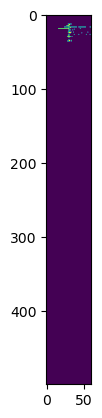

In [10]:
num_patients = 500
print(np.shape(time_strings))
plt.figure()
plt.imshow(time_strings[0:max(20, num_patients),:])
plt.show()

In [11]:
import pickle
data_dump_filename = "time_strings_20k.pickle"

with open(data_dump_filename, 'wb') as fh:
    pickle.dump(time_strings, fh)

### TODO
1. Clean up the dataframe of missing serial numbers
2. Find a better plotting to visualise all the time_strings together